# Libraries required

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
# !pip install klib
import klib
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost
from sklearn.metrics import accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Readind data

In [104]:
data = pd.read_csv('/content/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# EDA

In [105]:
# klib.clean_column_names(data)

In [106]:
data.columns = data.columns.str.lower()

In [107]:
data.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [108]:
data.shape

(918, 12)

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             918 non-null    int64  
 1   sex             918 non-null    object 
 2   chestpaintype   918 non-null    object 
 3   restingbp       918 non-null    int64  
 4   cholesterol     918 non-null    int64  
 5   fastingbs       918 non-null    int64  
 6   restingecg      918 non-null    object 
 7   maxhr           918 non-null    int64  
 8   exerciseangina  918 non-null    object 
 9   oldpeak         918 non-null    float64
 10  st_slope        918 non-null    object 
 11  heartdisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [110]:
data.isnull().sum()

age               0
sex               0
chestpaintype     0
restingbp         0
cholesterol       0
fastingbs         0
restingecg        0
maxhr             0
exerciseangina    0
oldpeak           0
st_slope          0
heartdisease      0
dtype: int64

In [111]:
data.sex.value_counts()

M    725
F    193
Name: sex, dtype: int64

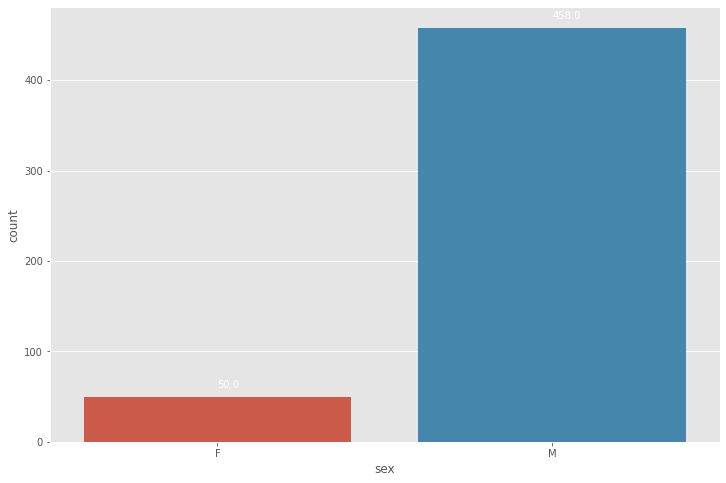

In [112]:
heart_prob = data[data['heartdisease'] == 1]
plt.figure(figsize=(12,8))
s = sns.countplot(heart_prob.sex)
for p in s.patches:
    s.annotate(format(p.get_height(), '.1f'), 
               (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext = (0, 9), 
                textcoords = 'offset points'
              )
plt.show()

Here we come to know that there are more number of males than the females who are prone to heart failures.

In [113]:
heart_prob.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,oldpeak,st_slope,heartdisease
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
11,58,M,ATA,136,164,0,ST,99,Y,2.0,Flat,1
13,49,M,ASY,140,234,0,Normal,140,Y,1.0,Flat,1


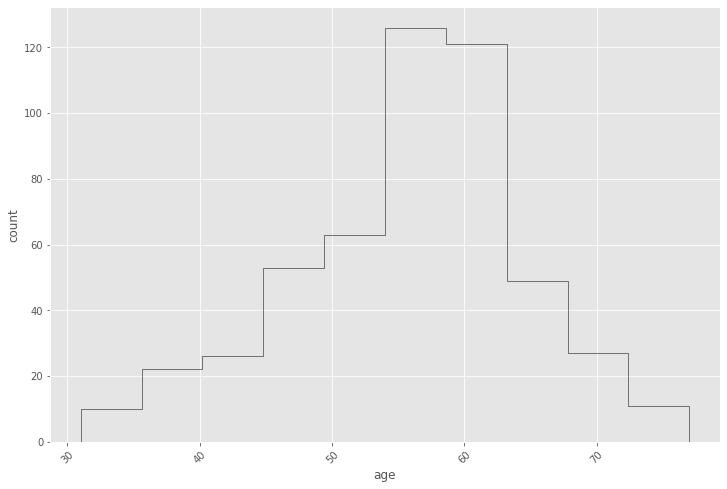

In [114]:
plt.figure(figsize=(12,8))
plt.hist(heart_prob.age, histtype='step', color='black')
plt.xlabel('age')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

By above graph, we get to know that most of heart risk is in between the age 50 to 60

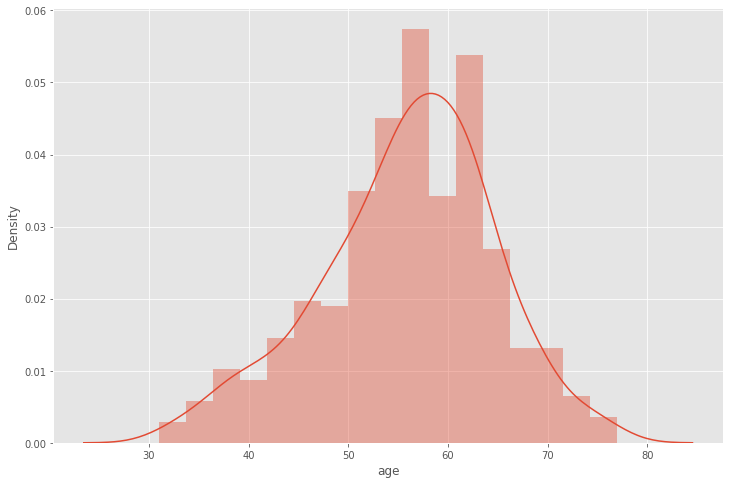

In [115]:
plt.figure(figsize=(12,8))
sns.distplot(heart_prob.age)
plt.show()

Age feature is asymptotically gaussian.

This plot shows the feature importances. Since the feature oldpeak is not important, we are removing that feature.

# Data Preparation

In [116]:
# dropping the 'oldpeak' feature
data.drop('oldpeak', axis=1, inplace=True)

In [117]:
data['sex'].replace({'M': 1, 'F': 0}, inplace=True)
data.chestpaintype.replace({'ASY': 0, 'NAP': 1, 'ATA': 2, 'TA': 3}, inplace=True)
data.restingecg.replace({'Normal': 0, 'LVH': 1, 'ST': 2}, inplace=True)
data['exerciseangina'].replace({'Y': 1, 'N': 0}, inplace=True)
data.st_slope.replace({'Flat': 0, 'Up': 1, 'Down': 2}, inplace=True)
data.head()

,age,sex,chestpaintype,restingbp,cholesterol,fastingbs,restingecg,maxhr,exerciseangina,st_slope,heartdisease
0,40,1,2,140,289,0,0,172,0,1,0
1,49,0,1,160,180,0,0,156,0,0,1
2,37,1,2,130,283,0,2,98,0,1,0
3,48,0,0,138,214,0,0,108,1,0,1
4,54,1,1,150,195,0,0,122,0,1,0


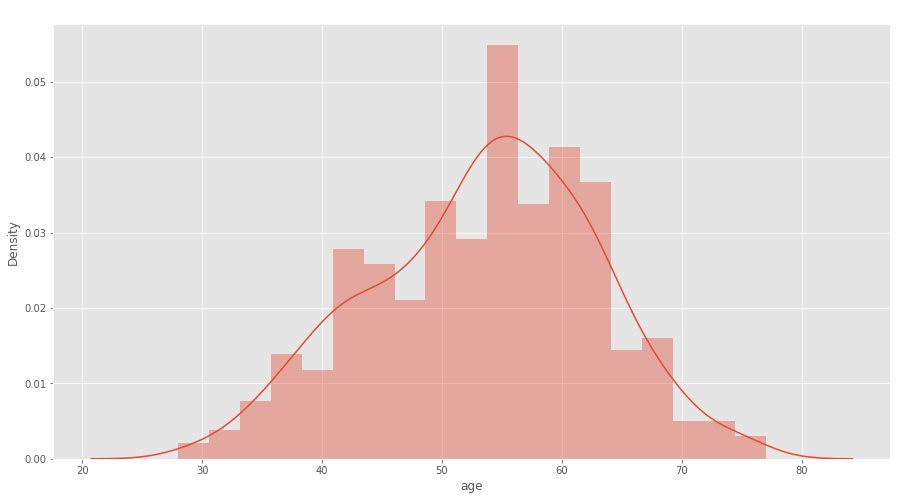

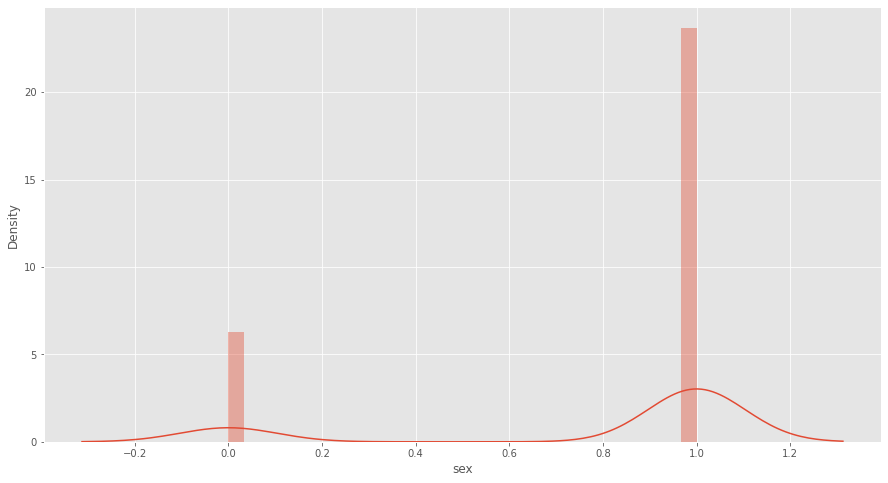

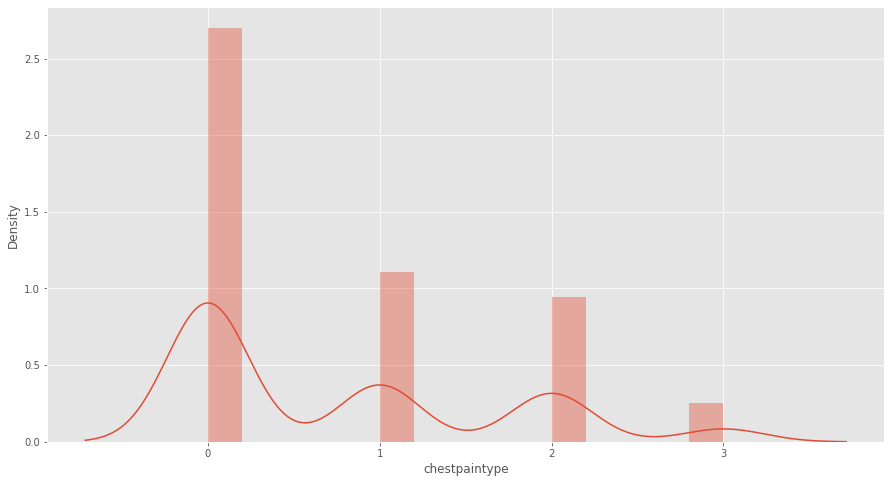

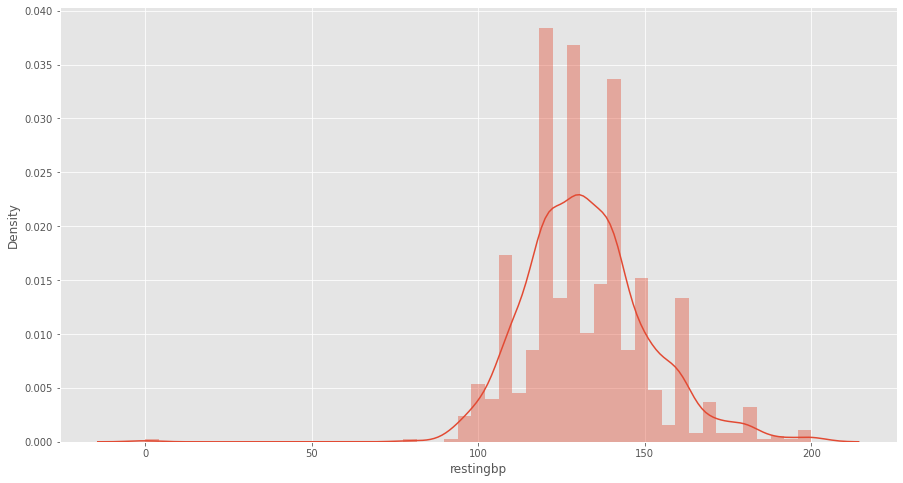

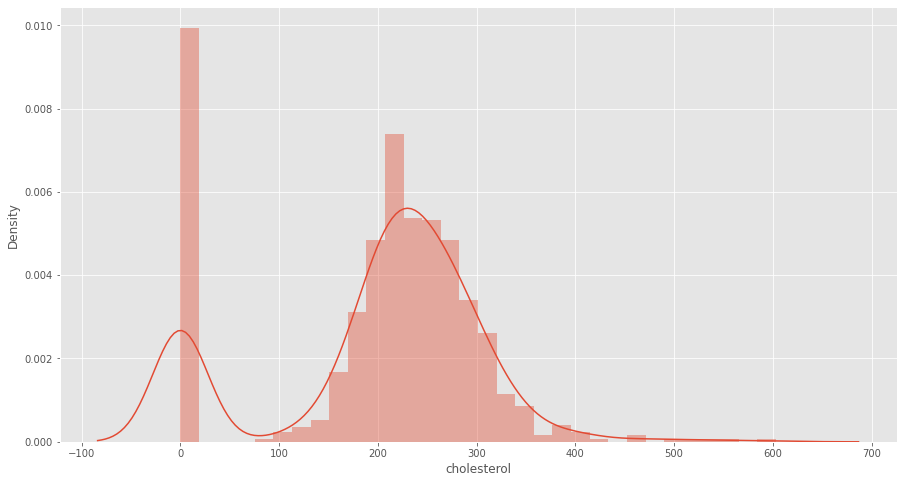

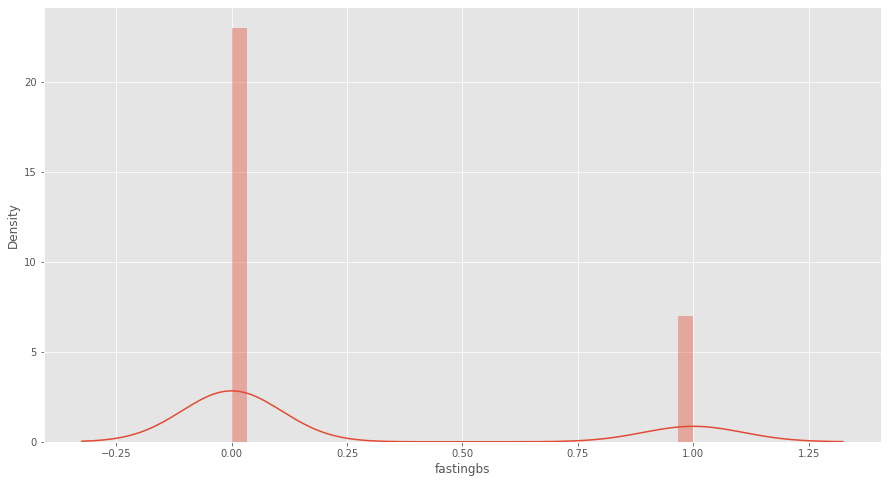

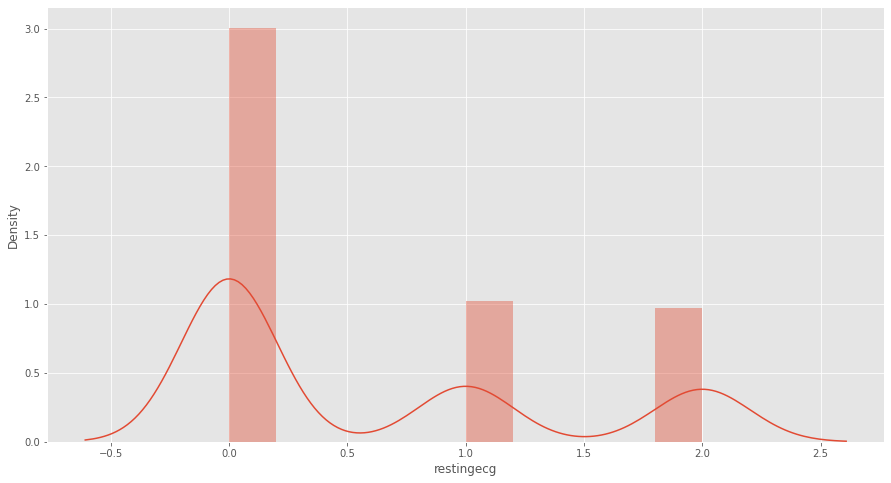

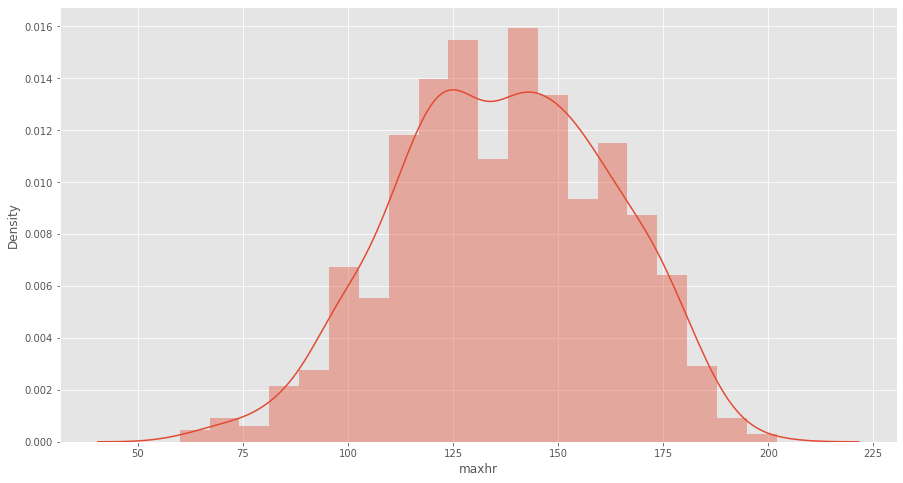

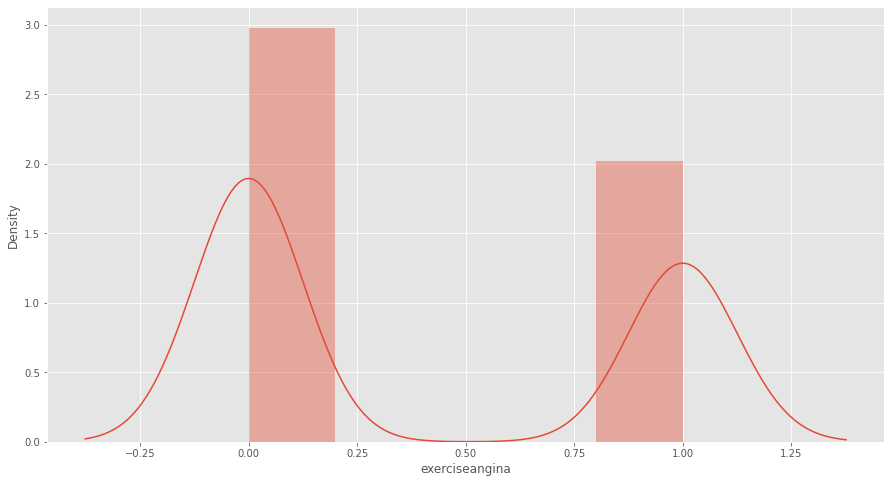

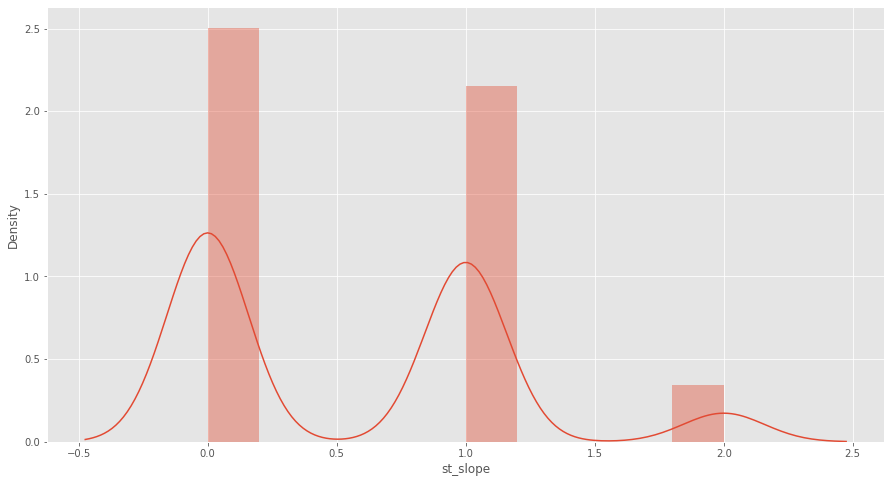

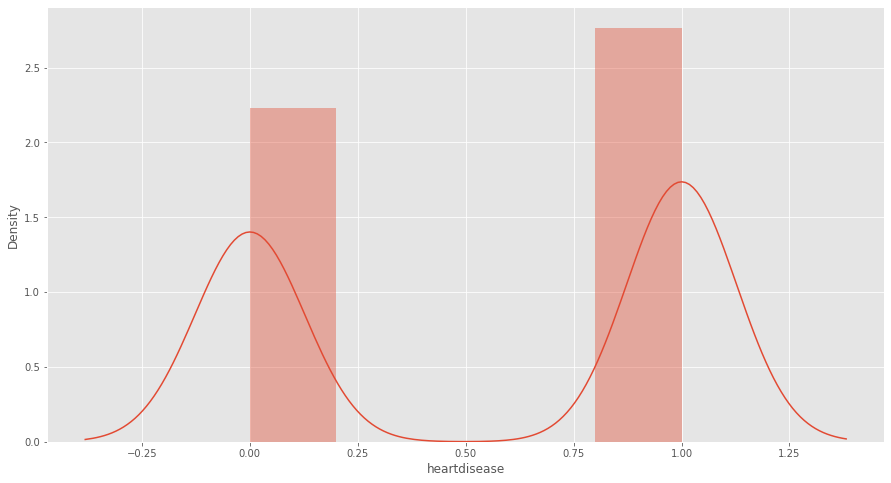

In [118]:
plt.title('Distribution plots of all features')
for cols in data.columns:
    sns.distplot(data[cols])
    plt.show()

All columns are asymptotically guassian

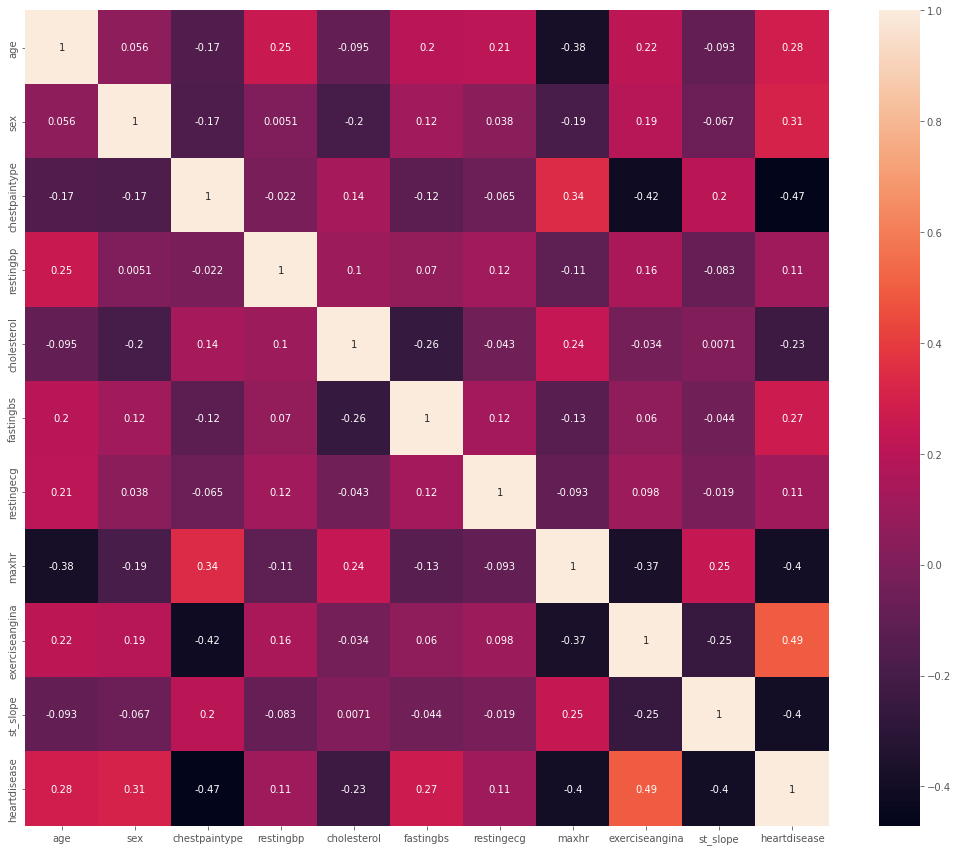

In [119]:
# shows how each feature is related with other features.
plt.figure(figsize=(18,15))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [120]:
X = data.drop('heartdisease', axis=1)
Y = data['heartdisease']

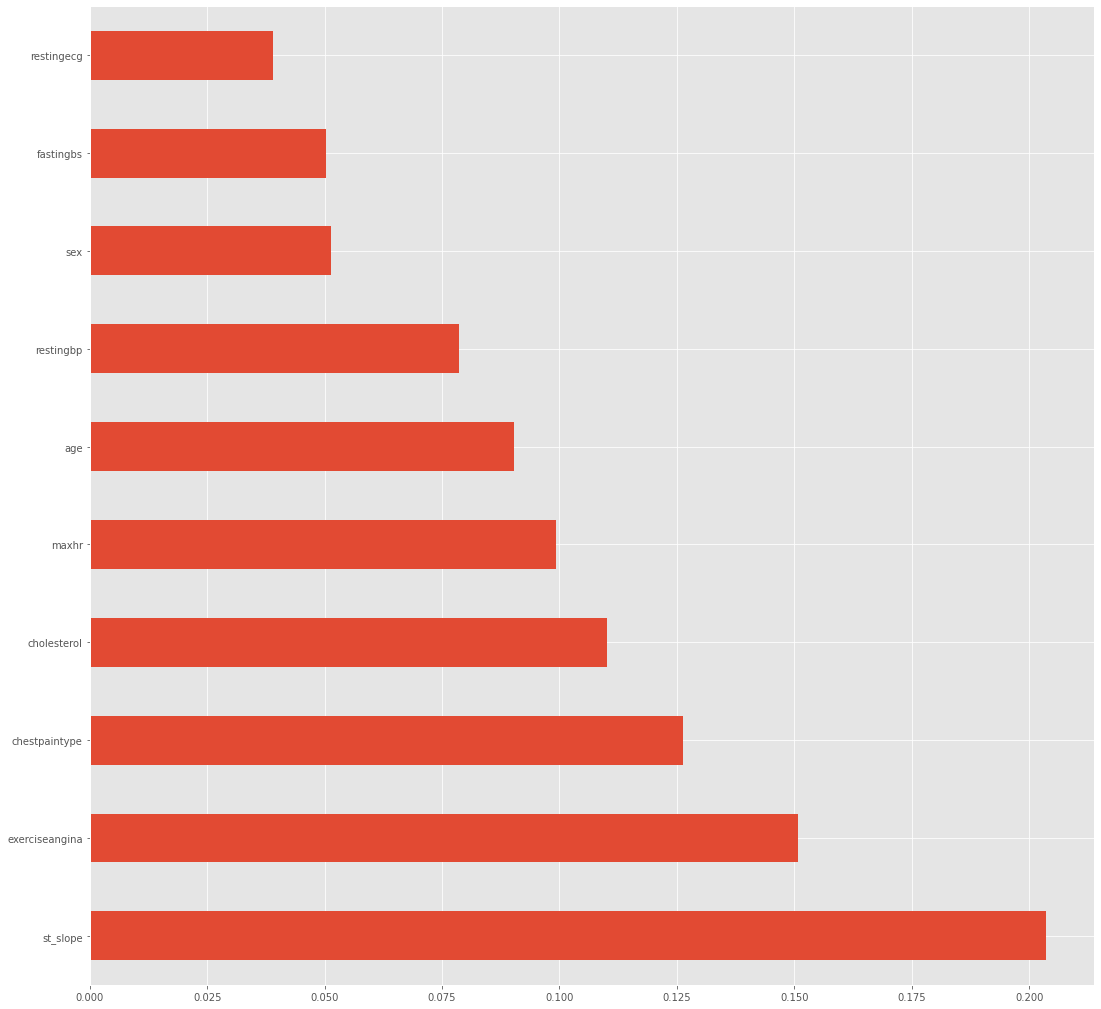

In [121]:
etr = ExtraTreesClassifier()
etr.fit(X, Y)

plt.figure(figsize=(18,18))
feature_imp = pd.Series(etr.feature_importances_, index=X.columns)
feature_imp.nlargest(len(X.columns)).plot(kind='barh')
plt.show()

In [122]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.1)

# Model Training and validation

In [123]:
lr = LogisticRegression(random_state=0)
sv = SVC(random_state=0)
rf = RandomForestClassifier(random_state=0)
dt = DecisionTreeClassifier(random_state=0)
xgb = xgboost.XGBClassifier(random_state=0)
gb = GradientBoostingClassifier(random_state=0)
models = [("Logistic Regression", lr),
          ("Support vectors", sv),
          ("Random Forest", rf),
          ("Decision Trees", dt),
          ("XGBoost", xgb),
          ('Gradient Boosting', gb)
         ]

In [124]:
results = []
names=[]
finalresults=[]

for name, model in models:
    model.fit(X_train, Y_train)
    model_results = model.predict(X_test)
    score= accuracy_score(Y_test, model_results)
    results.append(score)
    names.append(name)
    finalresults.append((name,score))

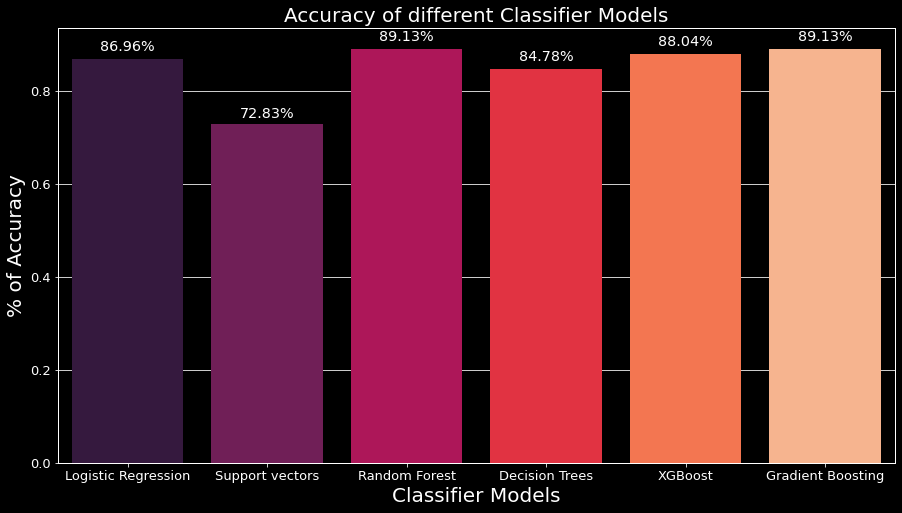

Random Forest has the highest accuracy of 89.1304%


In [127]:
# Visualising the accuracy score of each classification model
plt.rcParams['figure.figsize']=15,8 
plt.style.use('dark_background')
ax = sns.barplot(x=names, y=results, palette = "rocket", saturation =1.0)
plt.xlabel("Classifier Models", fontsize = 20 )
plt.ylabel("% of Accuracy", fontsize = 20)
plt.title("Accuracy of different Classifier Models", fontsize = 20)
plt.xticks(fontsize = 13, horizontalalignment = 'center', rotation = 0)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
#     print(width)
#     print(height)
plt.show()
index = results.index(max(results))
print(f"{names[index]} has the highest accuracy of {(max(results) * 100):.4f}%")

In [ ]:
# code to beep when previous cell completes its run

# from google.colab import output
# for _ in range(10):
#   output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [126]:
# open a file, where you ant to store the data
file = open('heart_risk.pkl', 'wb')

# dump information to that file
pickle.dump(rf, file)